In [1]:

import matplotlib.pyplot as plt
import os
import tensorflow as tf
import numpy as np
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [2]:


# 데이터 불러오기
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()



In [3]:
## 데이터를 (배치사이즈 x 28 x 28 x 1)로 이미지를 변환해줌. -> 그레이스케일이므로 채널은 1
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')

## 정답을 바이너리화 함.
Y_train = tf.keras.utils.to_categorical(Y_train)
Y_test = tf.keras.utils.to_categorical(Y_test)


In [4]:

# CNN 모델 설계.
## 모델
input_Layer = tf.keras.layers.Input(shape=(28,28,1))
x=tf.keras.layers.Conv2D(32,(3,3), strides=1, activation=None)(input_Layer)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),strides=1,activation=None)(x)
x=tf.keras.layers.MaxPool2D((2,2))(x)
x=tf.keras.layers.Flatten()(x)
x= tf.keras.layers.Dense(512, activation='relu')(x)
Out_Layer= tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=[input_Layer], outputs=[Out_Layer])


In [5]:
!pip3 install pydot
!pip3 install graphviz
!sudo apt install graphviz

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712

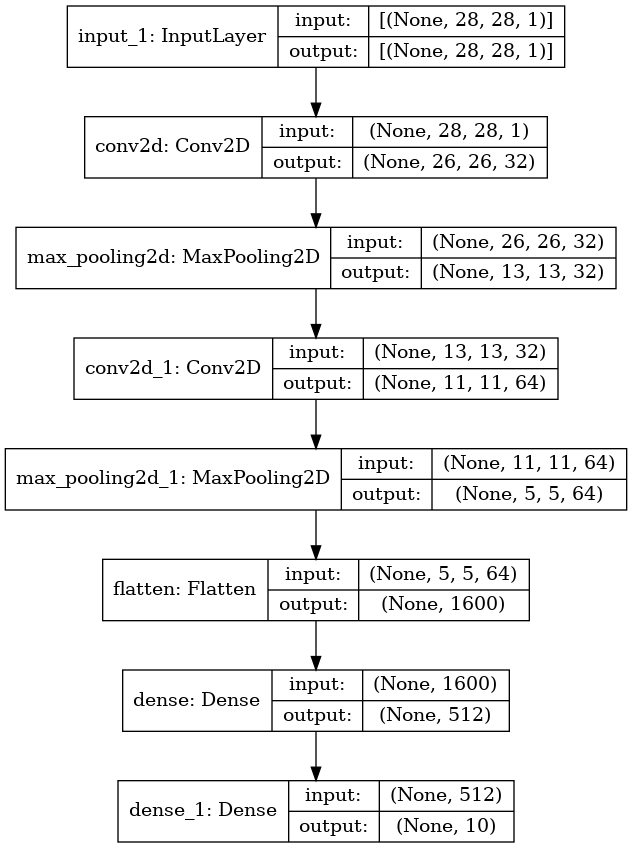

In [7]:

## 모델 비쥬얼 1
model.summary()

## 모델 비쥬얼 2
tf.keras.utils.plot_model(model, to_file='model_shapes.png', show_shapes=True)


In [ ]:

# tf.keras.utils.model_to_dot(model,show_shapes=True).
loss_function=tf.keras.losses.categorical_crossentropy
optimize=tf.keras.optimizers.RMSprop(learning_rate=0.0001)
metric=tf.keras.metrics.categorical_accuracy
model.compile(loss=loss_function,
              optimizer=optimize,
              metrics=[metric])

# 모델 최적화 설정
MODEL_DIR = './CNN_MNIST_model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath="./CNN_MNIST_model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# 모델의 실행
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=5, batch_size=200, verbose=1, callbacks=[early_stopping_callback,checkpointer])

# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))


In [ ]:

# 테스트 셋의 오차
y_vloss = history.history['val_loss']

# 학습셋의 오차
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()